In [35]:
using JLD2, LinearAlgebra, PyPlot, Tullio, Statistics, PottsGauge, DelimitedFiles

In [36]:
include("../src/dca_score.jl")
include("../src/utils.jl")
;

In [9]:
tt = ["A", "C", "F", "I", "L", "M", "V", "W", "Y", "P", "H", "K", "R", "D", "E", "N", "Q", "S", "T", "G"];

In [10]:
function int_matr(A; tt = tt, titolo = false, nametitle = "Interaction Matrix")
    matshow(A)
    xticks(0:19,tt)
    yticks(0:19,tt)
    tick_params(axis="both", which="both", bottom=false, top=false)
    if titolo == true
        title(nametitle)
    end        
    colorbar()
end

function zerosumgaug(m; mj = false)
    E_col = mean(m, dims = 2)
    E_row = mean(m, dims = 1)
    E_tot = mean(m)
    if mj == true
        res = -m .+ E_col .+ E_row .- E_tot;
    else
        res = m .- E_col .- E_row .+ E_tot
    end
    return res
end

function eigen_an(m, n_eig; tit = " ciao")  #the matrix should already be in the proper form
    l, vv = eigen(m)
    scatter(1:length(l), l);
    ord = sortperm(abs.(l), rev=true)
    ll = l[sortperm(abs.(l), rev=true)]
    scatter(ord[1:n_eig], ll[1:n_eig]);
    print("Explained Var : ")
    println(round.(cumsum(abs.(ll[1:n_eig]) ./ sum(abs.(l))), digits = 2))
    int_matr(m, titolo = true, nametitle = "Total " * tit)
    for i in 1:n_eig
        tit1 = "Proj l = $(round(ll[i], digits=2)) "
        int_matr(vv[:,ord[i]]' .* vv[:,ord[i]], titolo = true, nametitle = tit1 * tit); 
    end
end

function compute_mat_mf(m)
    Nf = length(m.Ks)
    H = size(m.V,2)
    JJ = []
    for f in 1:Nf
        @tullio J[i,j,a,b] := m.Ks[f][i,j,h]*m.V[a,h]*m.V[b,h]*(j!=i)
        push!(JJ, J)
    end
    J0 = [mean(mean(JJ[f], dims = 3), dims=4) for f in 1:Nf]  
    JJ_zs = [JJ[f] .- mean(JJ[f], dims = 3) .- mean(JJ[f], dims = 4) .+ J0[f] for f in 1:Nf]
    e_all = mean([dropdims(dropdims(mean(mean(JJ_zs[f], dims = 1), dims=2),
                    dims=1),dims=1) for f in 1:Nf])[1:20, 1:20]
    return e_all[order_Martin,order_Martin]
end

function compute_mat_sf(m)
    H = size(m.V,2)
    @tullio J[i,j,a,b] := m.K[i,j,h]*m.V[a,h]*m.V[b,h]*(j!=i)
    J0 = mean(mean(J, dims = 3), dims=4)  
    JJ_zs = J .- mean(J, dims = 3) .- mean(J, dims = 4) .+ J0 
    e_all = dropdims(dropdims(mean(mean(JJ_zs, dims = 1), dims=2),
                    dims=1),dims=1)[1:20, 1:20]
    return e_all[order_Martin,order_Martin]
end

function showVmat_mf(m, n_eig; tit = " ")
    @tullio VV[a, b, h] := m.V[a,h]*m.V[b,h]
    llh = mean([@tullio lam[h] := m1.Ks[f][i,j,h]*(j!=i) for f in 1:Nf]);
    ord = sortperm(abs.(llh), rev=true)
    ll = llh[sortperm(abs.(llh), rev=true)]
    close("all"); scatter(1:length(llh), llh)
    scatter(ord[1:n_eig], ll[1:n_eig])
    ex_var = round.(cumsum(abs.(ll[1:n_eig]) ./ sum(abs.(llh))), digits = 2)
    print("Explained variance : ")
    println(ex_var)
    for i in 1:n_eig
        int_matr(VV[order_Martin,order_Martin, ord[i]],
        titolo = true, nametitle = "Vmat l = $(round(ll[i], digits=2)) " * tit); 
    end
end

function showVmat_sf(m, n_eig; tit = " ")
    @tullio VV[a, b, h] := m.V[a,h]*m.V[b,h]
    @tullio llh[h] := m1.K[i,j,h]*(j!=i);
    ord = sortperm(abs.(llh), rev=true)
    ll = llh[sortperm(abs.(llh), rev=true)]
    close("all"); scatter(1:length(llh), llh)
    scatter(ord[1:n_eig], ll[1:n_eig])
    ex_var = round.(cumsum(abs.(ll[1:n_eig]) ./ sum(abs.(llh))), digits = 2)
    print("Explained variance : ")
    println(ex_var)
    for i in 1:n_eig
        int_matr(VV[order_Martin,order_Martin, ord[i]],
        titolo = true, nametitle = "Vmat l = $(round(ll[i], digits=2)) " * tit); 
    end
    return VV
end


  


showVmat_sf (generic function with 1 method)

In [11]:
@load "../../InteractionMatrix.jld2"

7-element Vector{Symbol}:
 :E
 :E1
 :E2
 :order_MJ
 :order_Martin
 :E1_natural
 :E1_martin

## Miyazawa Jernigan

Explained Var : [0.34, 0.53, 0.62, 0.7]


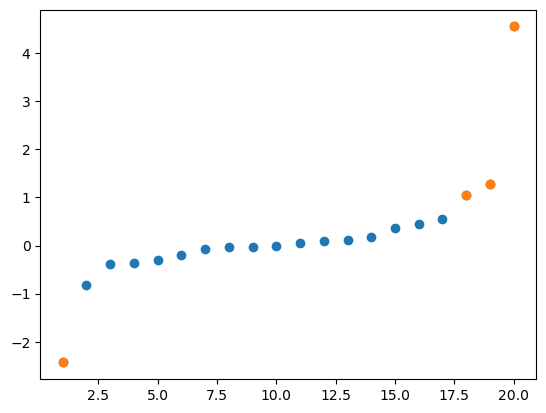

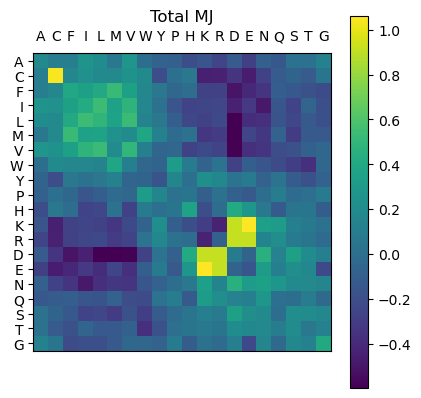

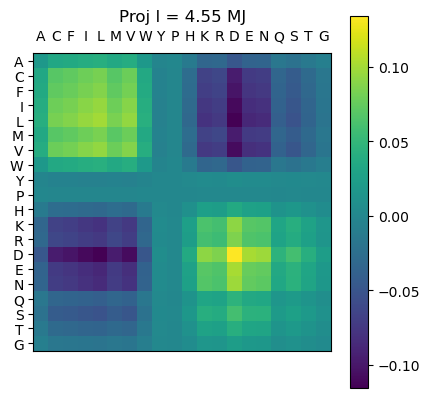

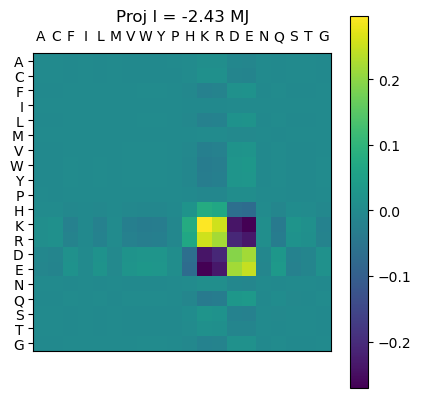

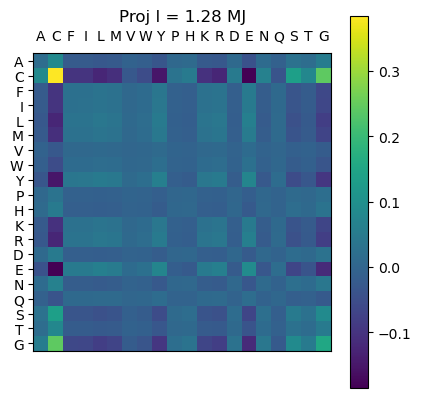

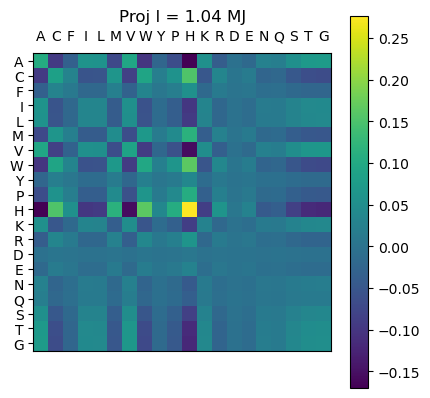

In [17]:
EE = zerosumgaug(E1_martin, mj = true)
n_eig = 4
eigen_an(EE, n_eig, tit = "MJ")

## HopfieldDCA reconstructing J like martin H = 20

[53, 116, 87, 70, 67]
N = 116, H = 21
(38,)
(71,)
(10,)
(89,)
(10,)
Explained Var : [0.11, 0.2, 0.28, 0.36, 0.44, 0.5]


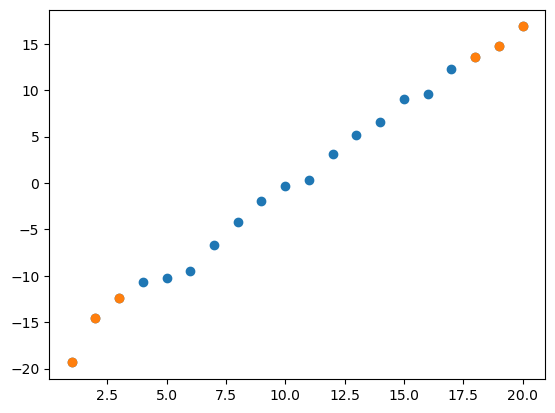

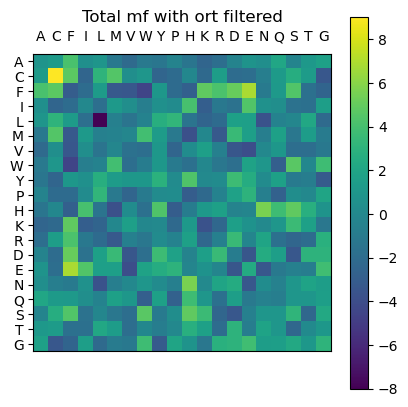

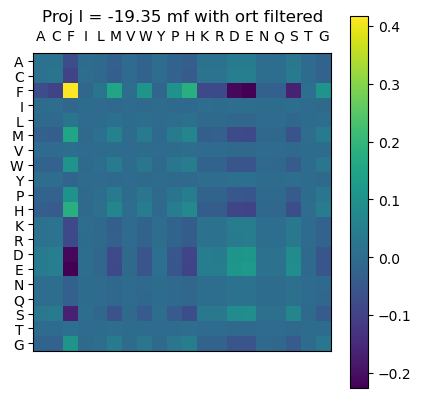

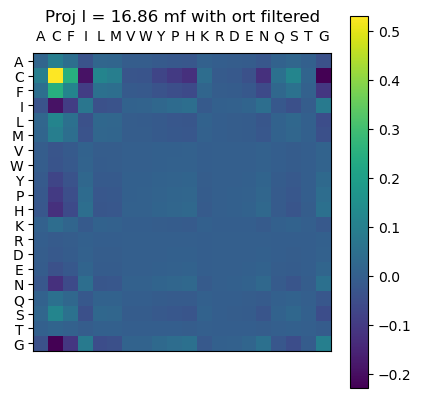

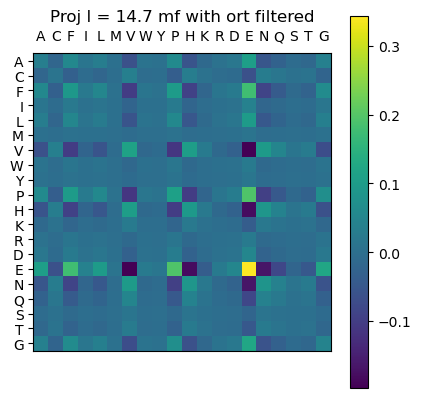

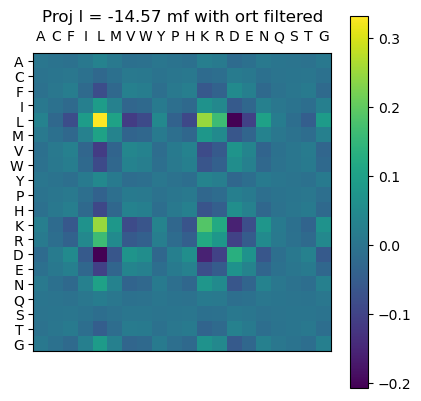

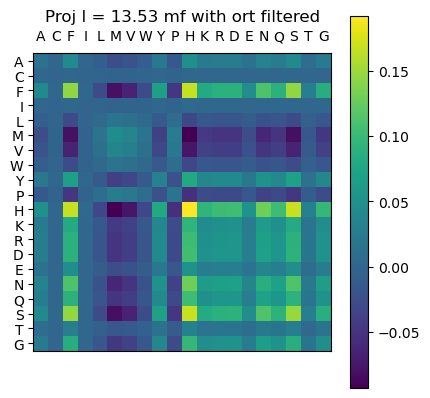

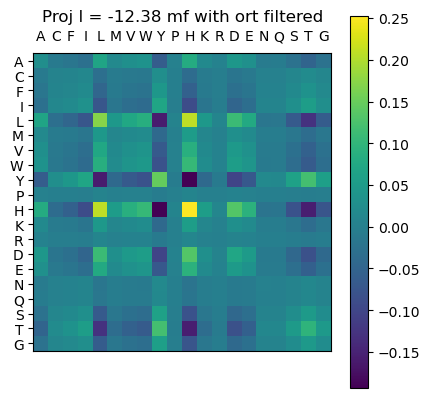

In [38]:
@load "../../multi_fam/orttrue_H21η0.01λ0.001/mf_pars35_H21η0.01λ0.001T90.jld2"
m1 = m ; n_eig = 6;
structfiles = ["../../DataAttentionDCA/data/PF00014/PF00014_struct.dat", 
    "../../DataAttentionDCA/data/PF00763/Atomic_distances_PF00763.dat",
    "../../DataAttentionDCA/data/PF00677/Atomic_distances_PF00677.dat",
    "../../DataAttentionDCA/data/PF00076/PF00076_struct.dat",
    "../../DataAttentionDCA/data/PF00035/Atomic_distances_PF00035.dat"]
aa = get_filt_mat_mf(m1.Ks, m1.V, structfiles, ppv_cutoff = 0.98)[order_Martin, order_Martin]
eigen_an(aa, n_eig, tit = "mf with ort filtered")
;

Explained Var : Float32[0.17, 0.3, 0.41, 0.51, 0.6, 0.68]


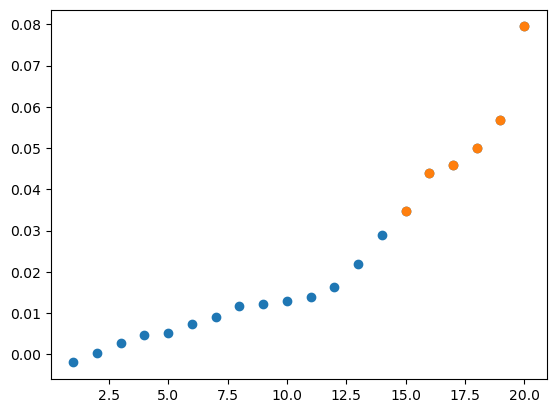

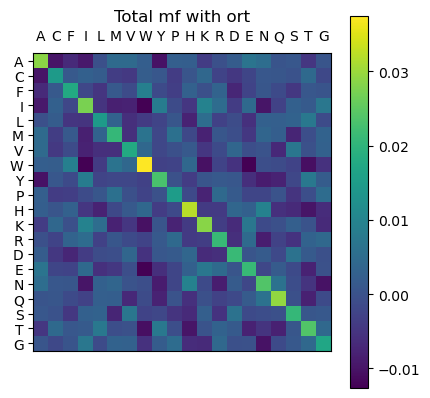

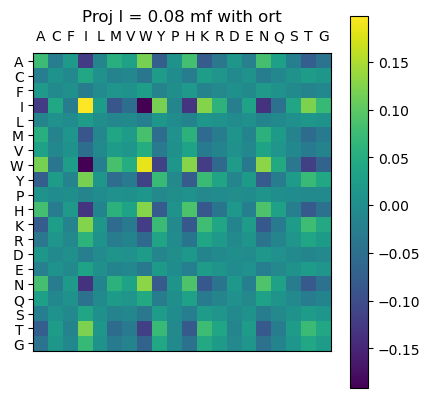

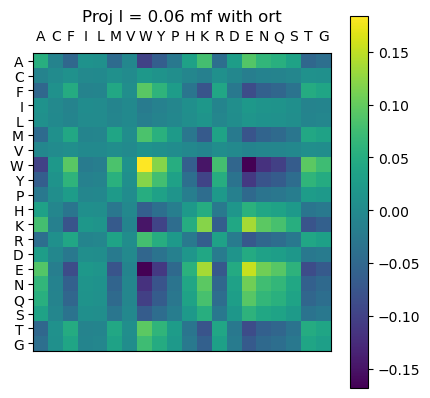

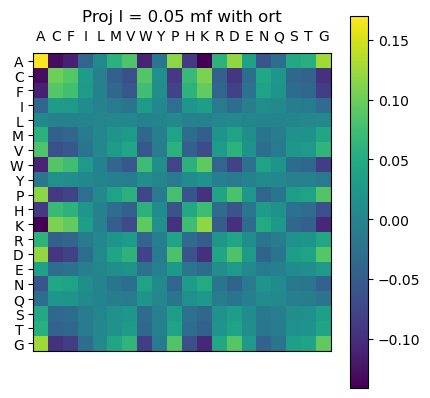

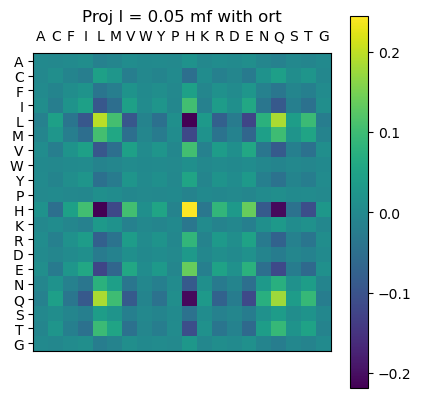

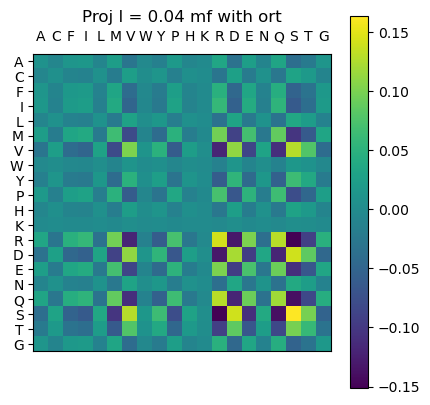

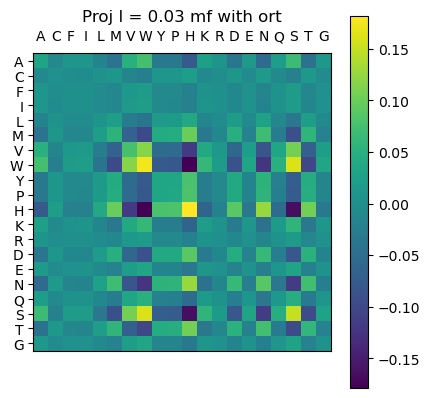

In [8]:
@load "../../multi_fam/orttrue_H21η0.01λ0.001/mf_pars35_H21η0.01λ0.001T90.jld2"
m1 = m ; n_eig = 6;
aa = compute_mat_mf(m1)
eigen_an(aa, n_eig, tit = "mf with ort")
;

Explained variance : Float32[0.18, 0.33, 0.43, 0.52, 0.6, 0.68]


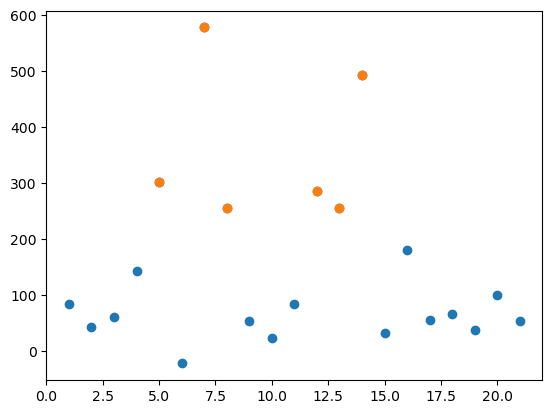

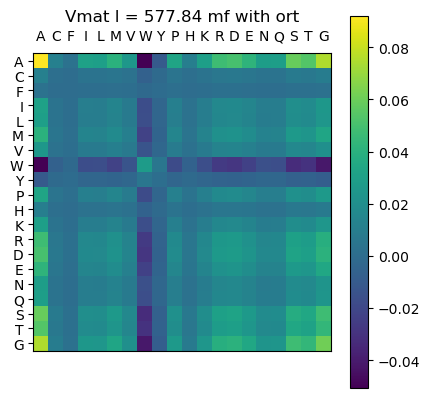

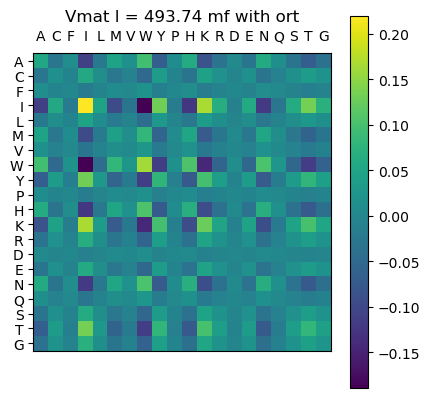

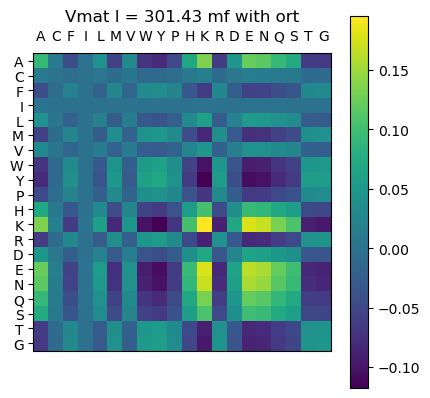

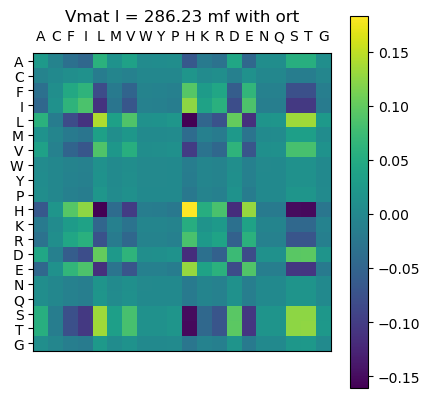

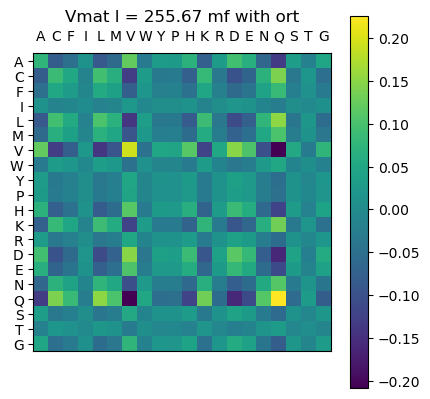

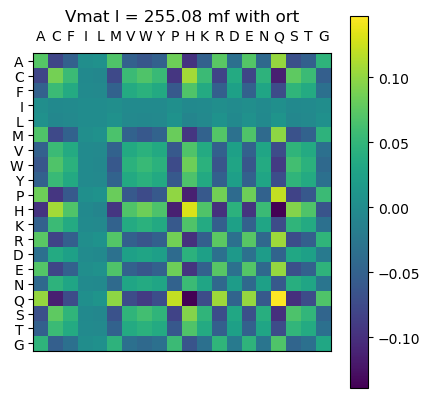

In [159]:
@load "../../multi_fam/orttrue_H21η0.01λ0.001/mf_pars35_H21η0.01λ0.001T90.jld2"
m1 = m ; n_eig = 6;
showVmat_mf(m1, n_eig, tit = "mf with ort")
;

c
Explained Var : [0.13, 0.24, 0.35, 0.43, 0.51, 0.57]


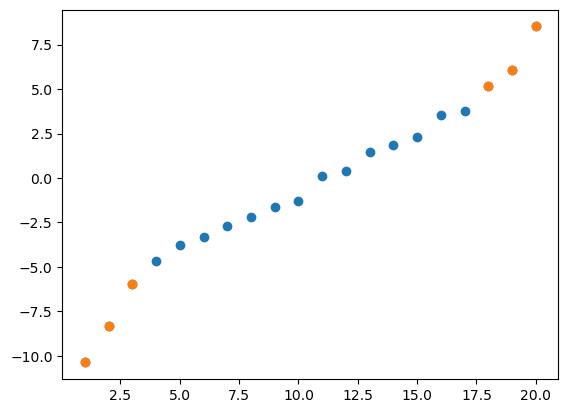

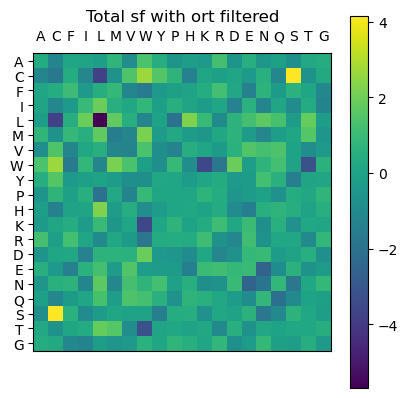

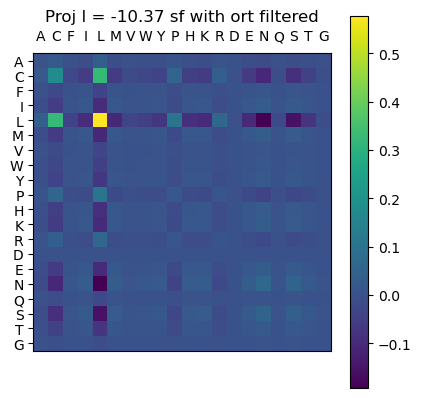

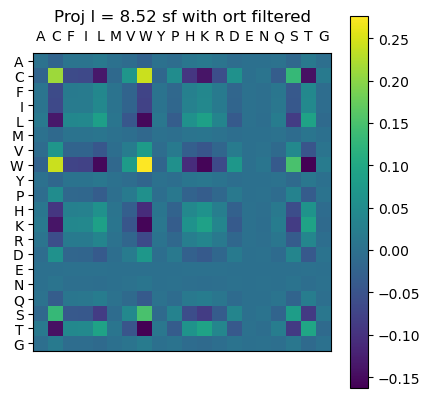

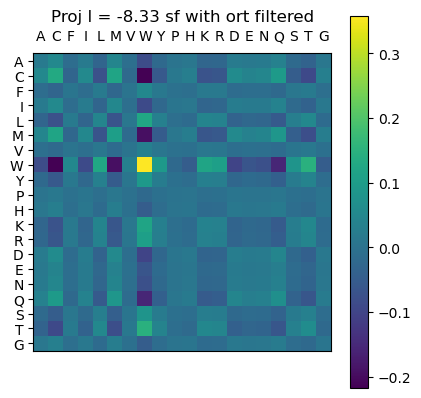

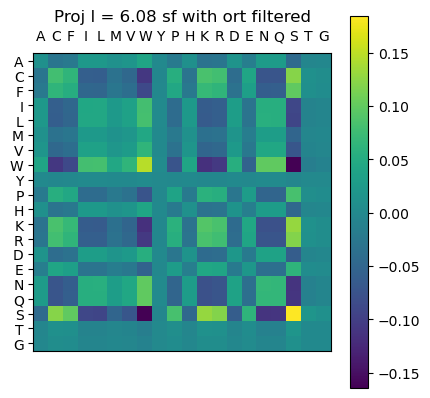

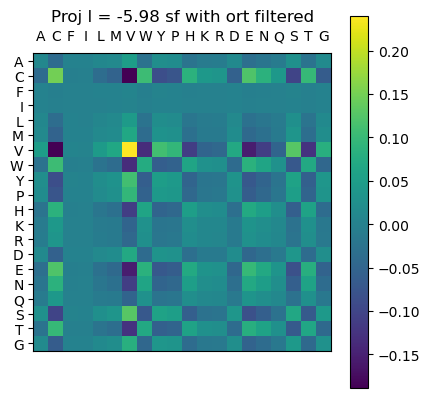

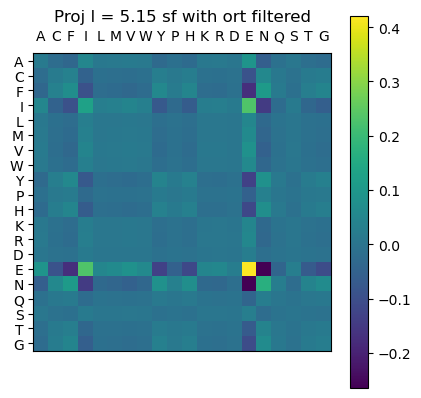

In [14]:
@load "../../DataAttentionDCA/data/PF00014/orttrue_parsH21η0.05λ0.001T60.jld2"
m1 = m ; n_eig = 6;
aa = get_filt_mat_sf(m1.K, m1.V, "../../DataAttentionDCA/data/PF00014/PF00014_struct.dat",
    ppv_cutoff = 0.9)[order_Martin, order_Martin]
eigen_an(aa, n_eig, tit = "sf with ort filtered")
;

Explained Var : Float32[0.18, 0.29, 0.37, 0.44, 0.51, 0.58]


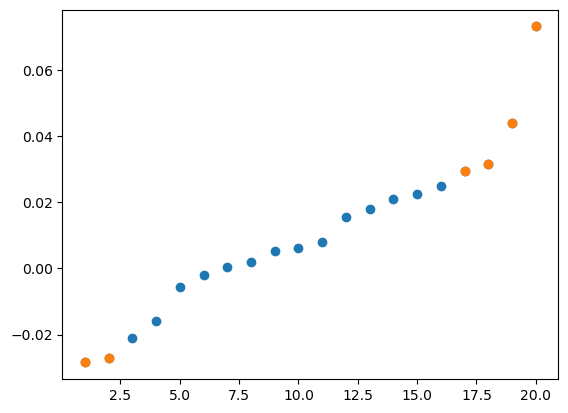

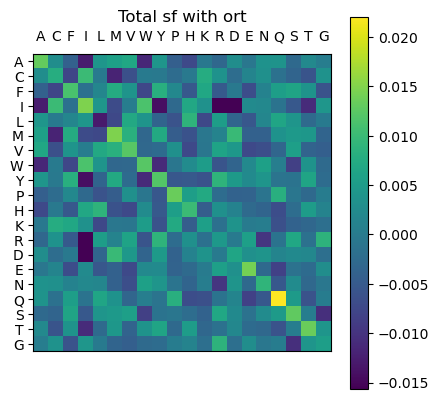

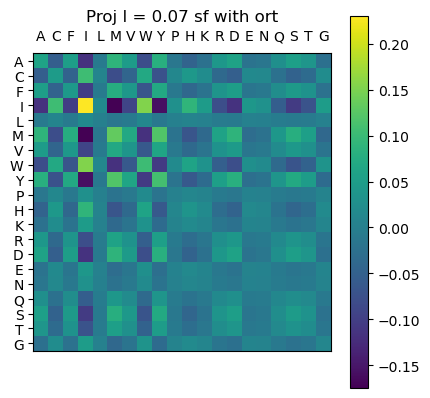

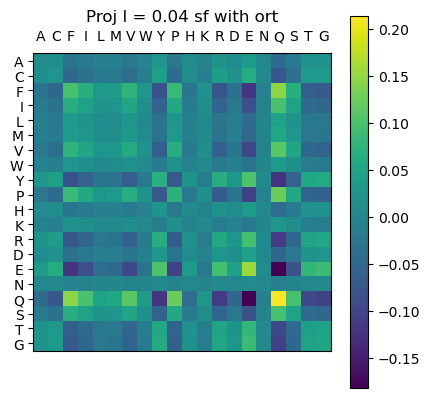

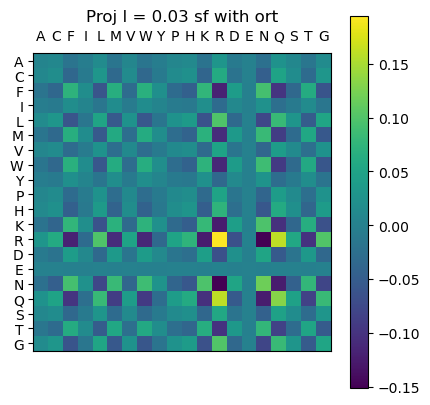

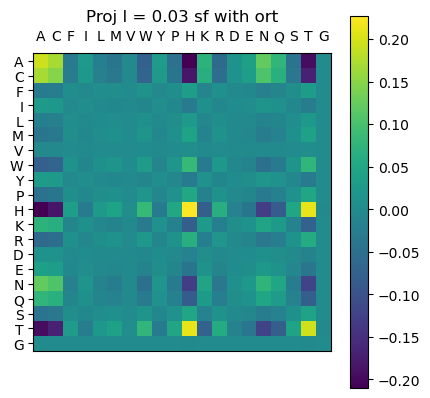

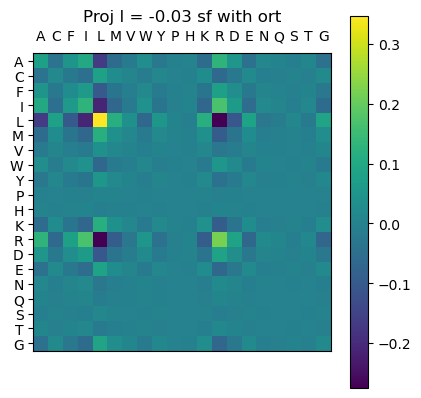

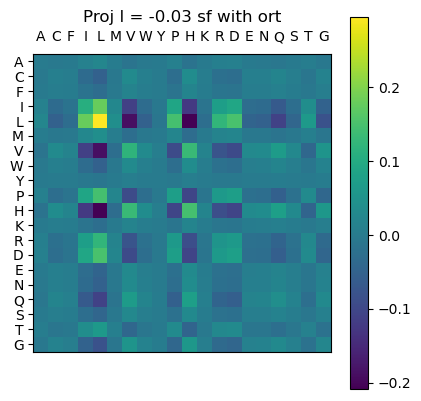

In [152]:
@load "../../DataAttentionDCA/data/PF00014/orttrue_parsH21η0.05λ0.001T60.jld2"
m1 = m ;n_eig = 6; 
#single family
aa = compute_mat_sf(m1)
eigen_an(aa, n_eig, tit = "sf with ort")
;

Explained variance : Float32[0.22, 0.32, 0.39, 0.45, 0.51, 0.57]


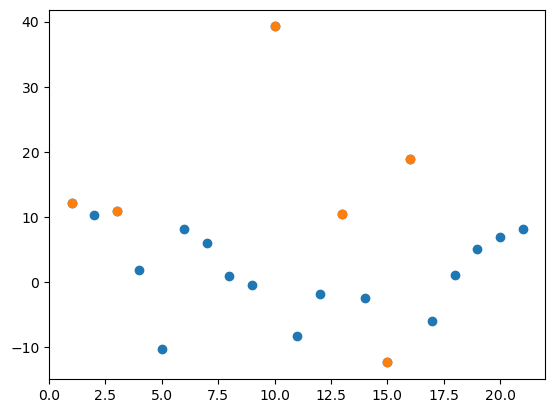

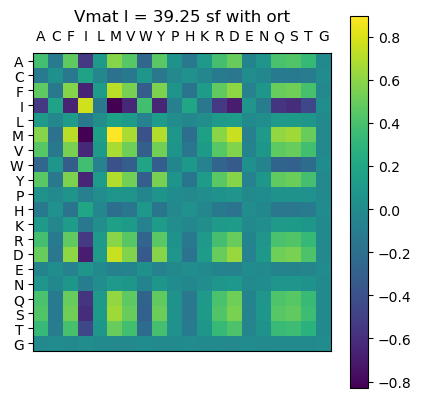

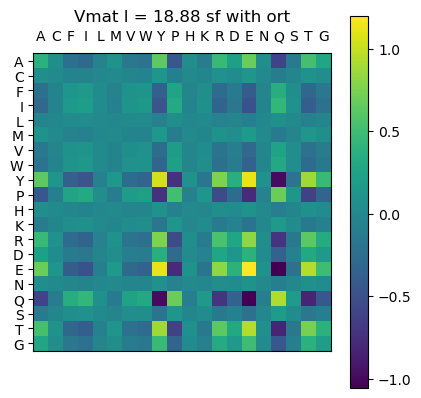

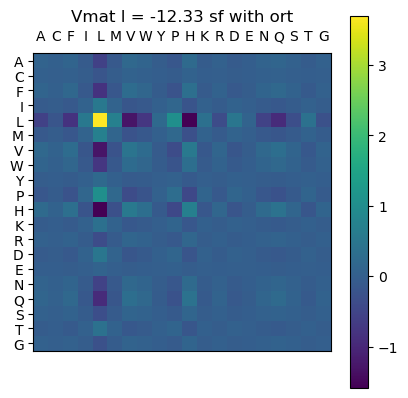

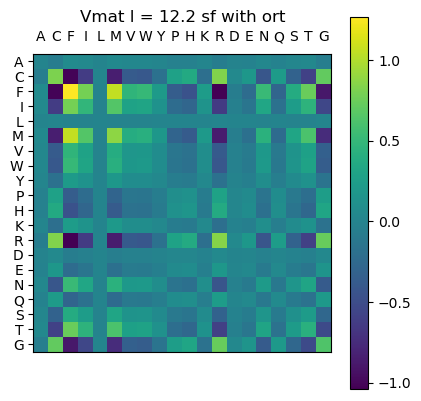

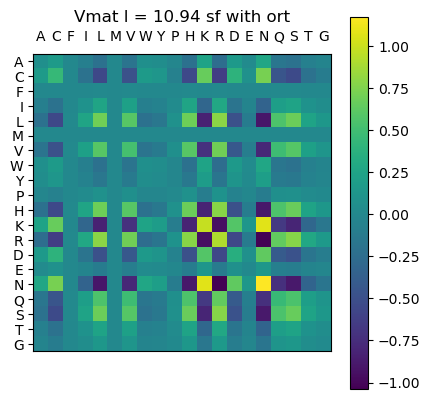

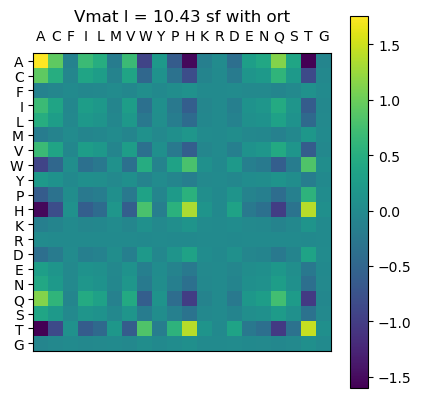

In [157]:
@load "../../DataAttentionDCA/data/PF00014/orttrue_parsH21η0.05λ0.001T60.jld2"
m1 = m ; n_eig = 6; 
showVmat_sf(m1, n_eig, tit = "sf with ort");

Explained Var : Float32[0.22, 0.39, 0.51, 0.6, 0.68, 0.75]


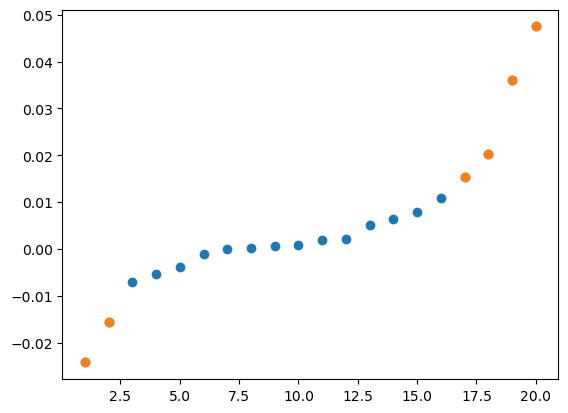

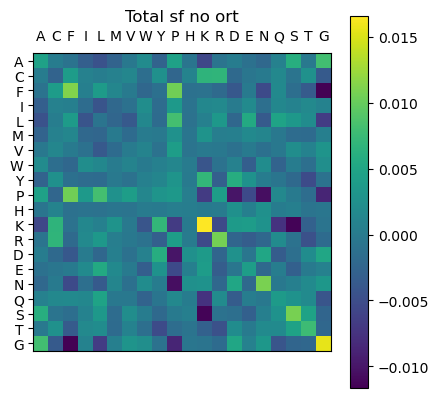

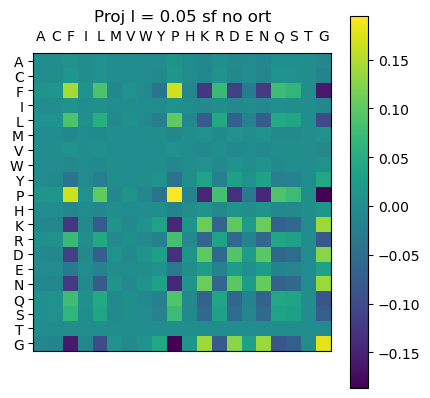

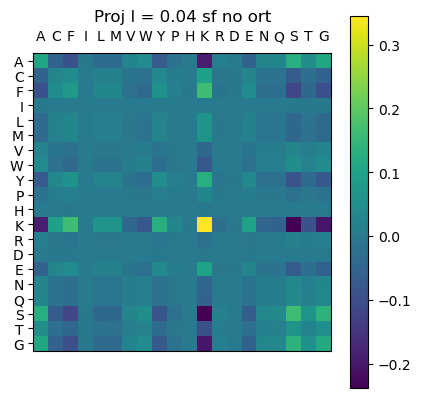

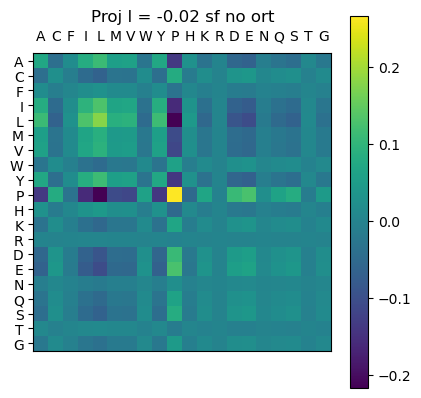

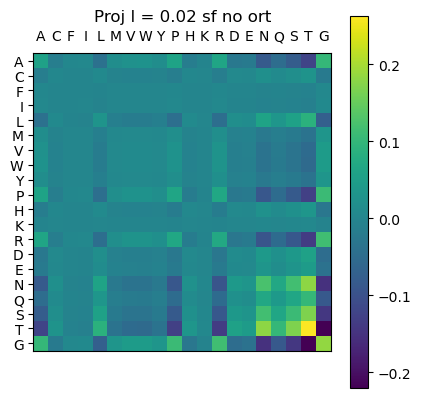

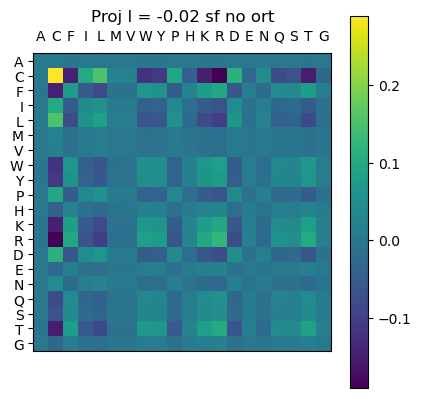

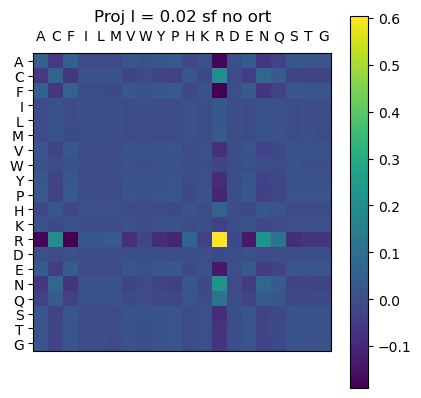

In [154]:
@load "../../DataAttentionDCA/data/PF00014/ortfalse_parsH21η0.5λ0.001T200.jld2"
m1 = m ; n_eig = 6;
#single family
aa = compute_mat_sf(m1)
eigen_an(aa, n_eig, tit = "sf no ort")
;


Explained variance : Float32[0.16, 0.25, 0.34, 0.43, 0.51, 0.59]


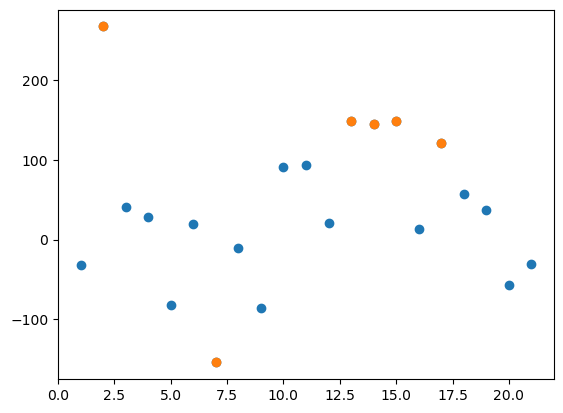

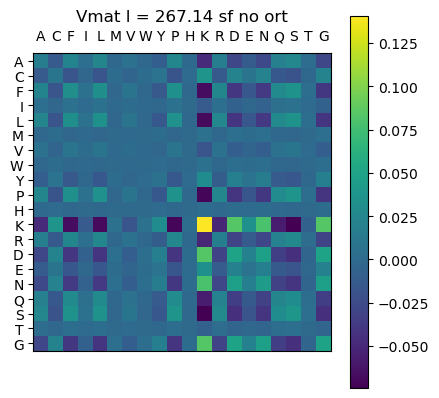

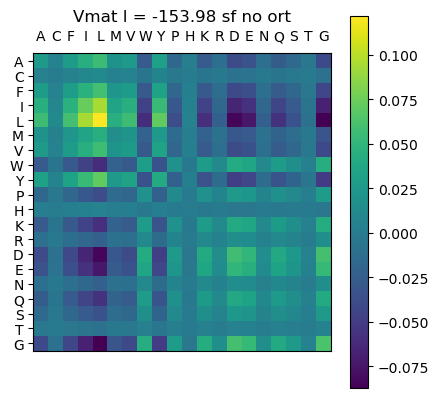

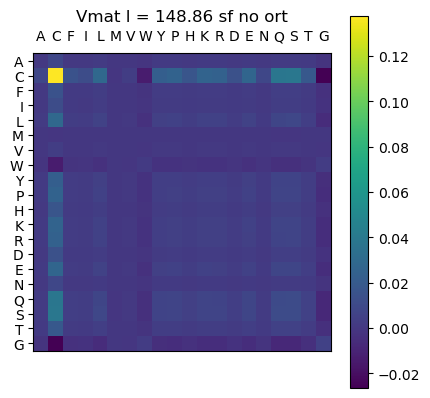

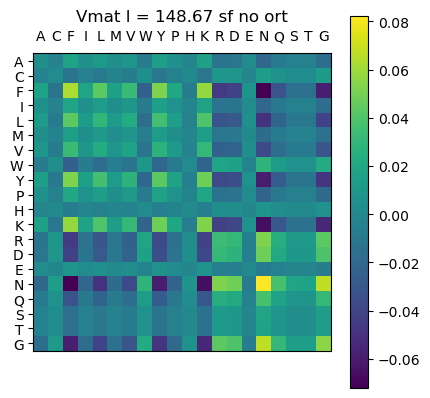

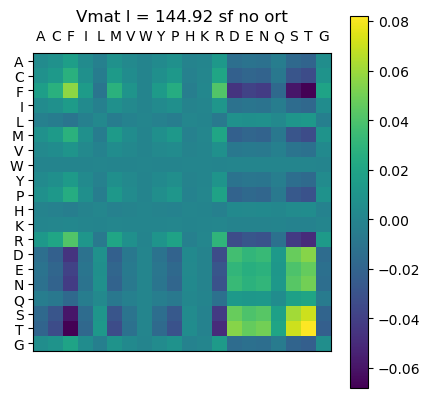

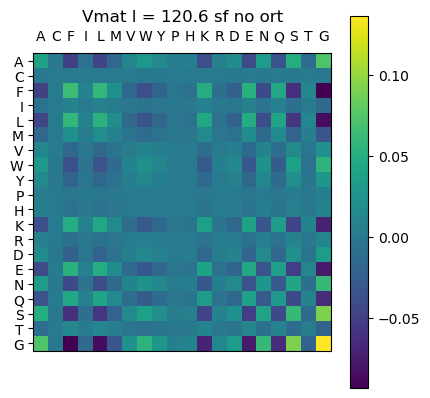

In [143]:
@load "../../DataAttentionDCA/data/PF00014/ortfalse_parsH21η0.5λ0.001T200.jld2"
m1 = m ; n_eig = 6; 
VV1 = showVmat_sf(m1, n_eig, tit = "sf no ort");

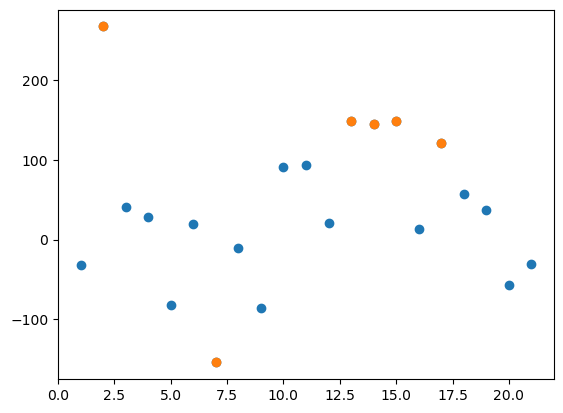

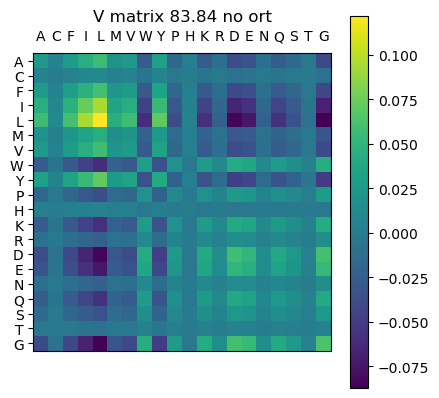

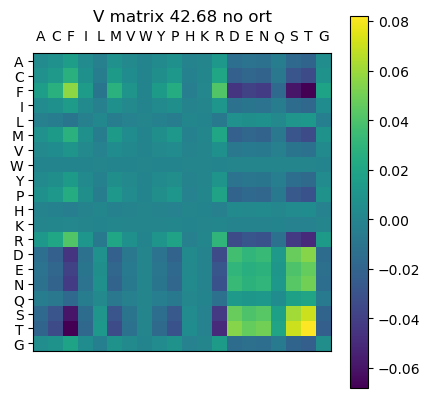

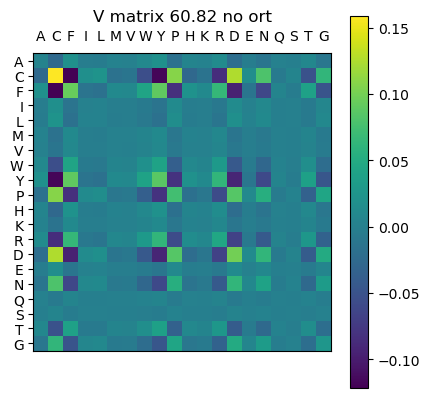

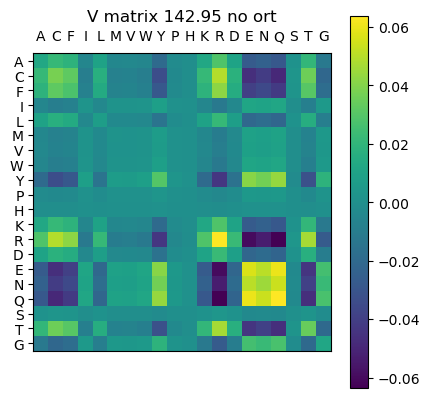

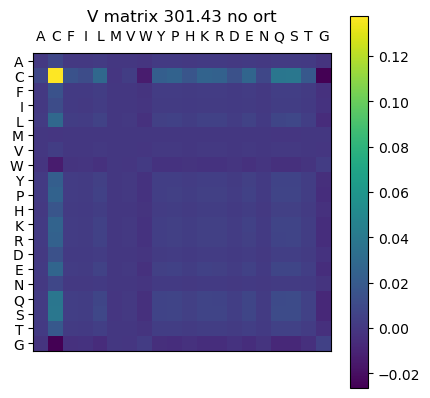

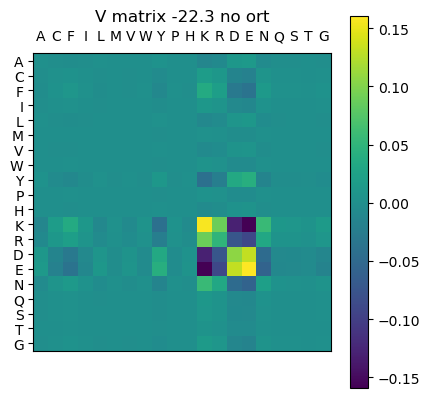

In [156]:
@load "../../DataAttentionDCA/data/PF00014/ortfalse_parsH21η0.5λ0.001T200.jld2"
m1 = m ; n_eig = 6;
#single family
@tullio VV[a, b, h] := m1.V[a,h]*m1.V[b,h]
@tullio ll[h] := m1.K[i,j,h]*(j!=i);

close("all"); scatter(1:length(ll), ll)
scatter(sortperm(abs.(ll), rev=true)[1:n_eig], ll[sortperm(abs.(ll), rev=true)][1:n_eig])
ex_var = round.(abs.(ll[sortperm(abs.(ll), rev=true)][1:n_eig]) ./ sum(abs.(ll)), digits = 3) 
#plot(1:n_eig, cumsum(ex_var), label = "Explained Variance")
#plt.legend()
for i in 1:n_eig
    int_matr(VV[order_Martin, order_Martin, sortperm(abs.(llh), rev=true)[i]],
        titolo = true, nametitle = "V matrix $(round(llh[i], digits=2)) no ort"); 
end

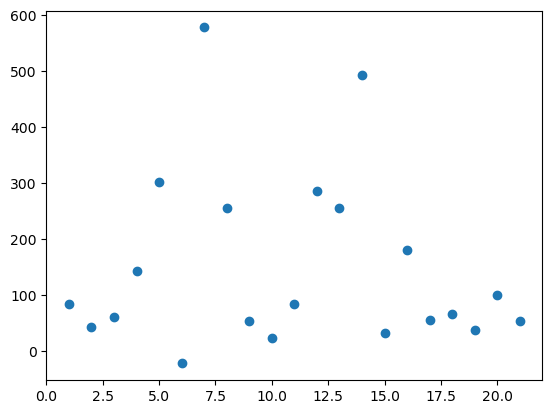

PyObject <matplotlib.collections.PathCollection object at 0x7fa2c23a23d0>

In [158]:
scatter(1:length(llh), llh)

In [162]:
llh[sortperm(abs.(llh), rev=true)[6]]

255.07925f0